<img src="./materiales/urjc_logo.png" width="200" height="100" align="right"/>

# <span style="color:darkcyan"> Práctica 1: Filtrado y mejora de imagen médica  </span>

<div style="text-align: center"><font size="3"><i><b>Jupyter Notebook elaborado por: David María Arribas, Paula Sánchez Tirado y Katherine Coutinho García</b></i></font></div>

<div class="warning" style=' background-color:#c4fbff'>
<span><font size="4">
<p style='margin-top:1em; text-align:center'>
<b>Implementación</b></p>
</font>
</span>
</div>

In [1]:
# Descomentar para obtener los gráficos en ventanas independientes
# %matplotlib tk
import cv2.cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import os

from noise import add_noise, NoiseTypes
from dif_aniso import dif_aniso, dif_aniso_mc
from nlm_filter import nlm

In [2]:
def read_image(file):
    image = cv2.imread(file, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float64)
    return image

# <span style="color:darkcyan">EJERCICIO 1</span>

## <span style="color:darkcyan"> Ejercicio 1.1: Filtrado anisotrópico un solo canal  </span>

Se he implementado en python, dentro de dif_aniso.py la función matlab que se incluye como parte de los ejercicios.

###  <span style="color:darkcyan"> - Determinando el parámetro K</span>

Para determinar el valor del parámetro K, se han generado las imágenes de gradientes en las 4 direcciones y se ha analizado el valor del gradiente en las zonas de bajo contraste cuyos bordes queremos mantener.

De esta forma hemos determinado que el valor que búscamos para el parámetro K es 8.

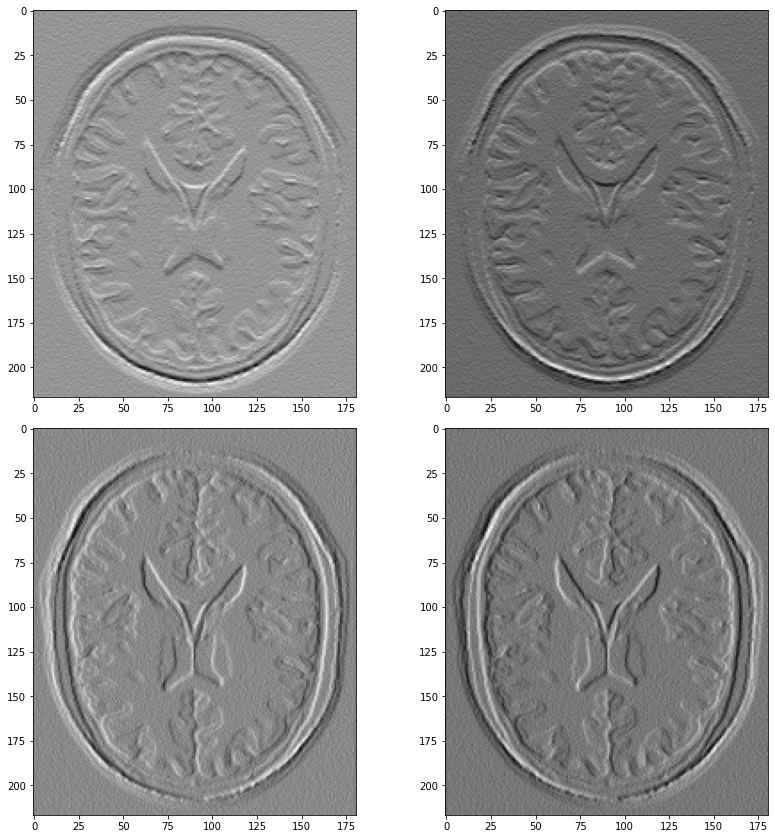

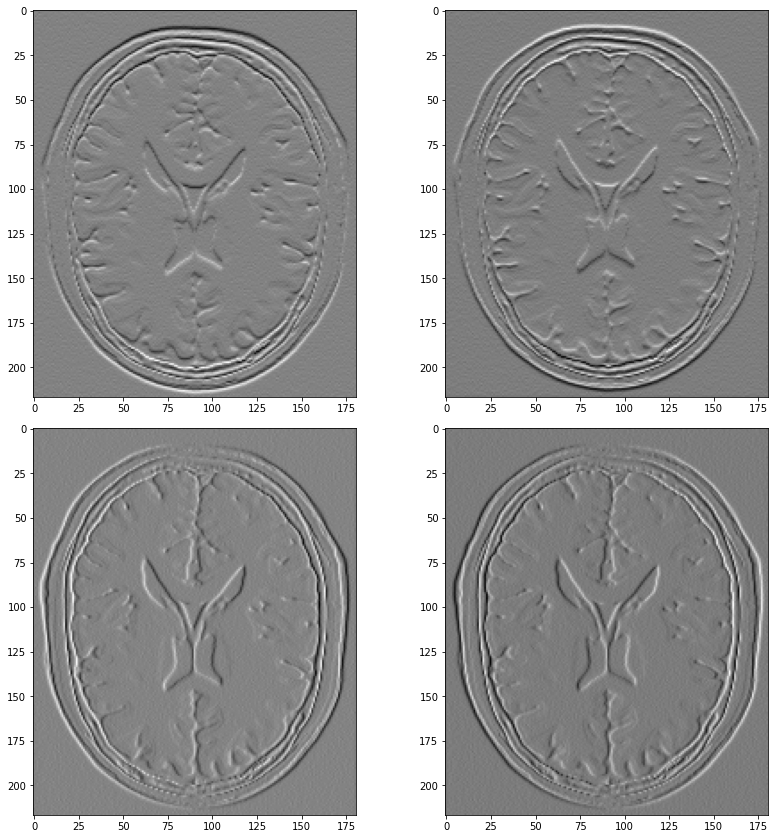

In [5]:
def show_gradients(image_file):
    image = read_image(image_file)
    image = add_noise(image=image, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)
    rows, cols = image.shape

    # pads image with zeros
    imdifm = np.pad(image, (1,), constant_values=0, mode='constant')

    # gradients in 4 directions
    deltaN = imdifm[0:rows, 1:cols + 1] - image
    deltaS = imdifm[2:rows + 2, 1:cols + 1] - image
    deltaE = imdifm[1:rows + 1, 2:cols + 2] - image
    deltaW = imdifm[1:rows + 1, 0:cols] - image

    fig, ax = plt.subplots(2, 2, figsize=(12, 12), tight_layout={
        'rect': [0, 0, 1, 0.98] }
    )
    ax[0,0].imshow(deltaN, cmap='gray')
    ax[0,1].imshow(deltaS, cmap='gray')
    ax[1,0].imshow(deltaE, cmap='gray')
    ax[1,1].imshow(deltaW, cmap='gray')

show_gradients("materiales/T1.png")
show_gradients("materiales/T2.png")

###  <span style="color:darkcyan"> - Realizando el filtrado en T1.png</span>

Se ha realizado y presentado el filtrado en T1.png con el parámetro K deducido con el método anteriormente comentado y numero de iteraciones y valor de lambda probados de forma empírica.

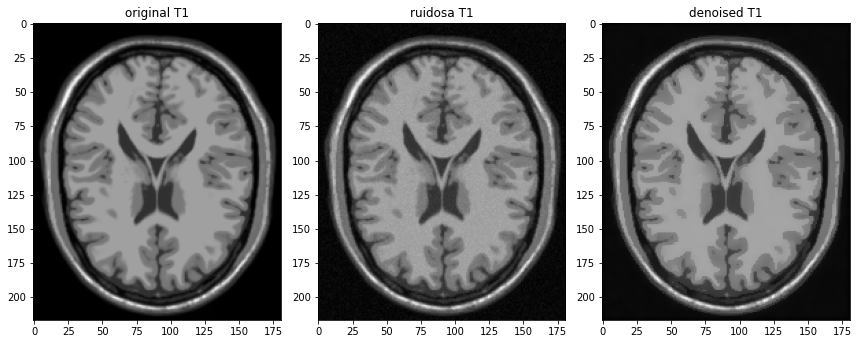

In [7]:
def filter_image(image_file):
    file = os.path.basename(image_file)
    file = os.path.splitext(file)[0]
    imageT1 = read_image(image_file)
    noise_image = add_noise(image=imageT1, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)
    denoised_image = dif_aniso(im=noise_image, niter=10, k=8, l=0.40, option=1)

    fig, ax = plt.subplots(1, 3, figsize=(12, 11), tight_layout={
            'rect': [0, 0, 1, 0.98]
        }
    )
    ax[0].imshow(imageT1, cmap='gray')
    ax[0].set_title(f"original {file}")
    ax[1].imshow(noise_image, cmap='gray')
    ax[1].set_title(f"ruidosa {file}")
    ax[2].imshow(denoised_image, cmap='gray')
    ax[2].set_title(f"denoised {file}")

filter_image("materiales/T1.png")

Y hacemos lo mismo para T2.

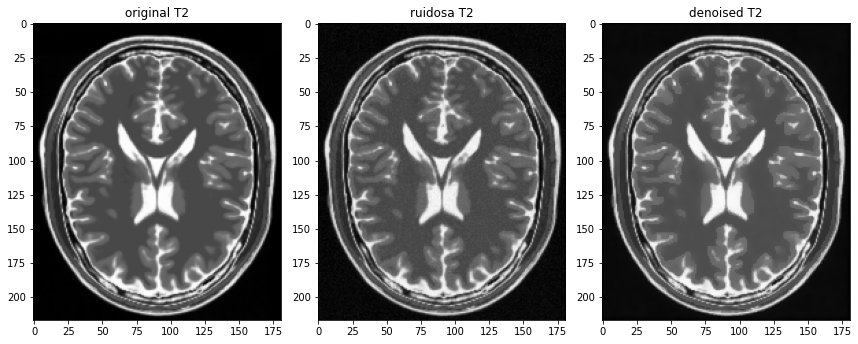

In [8]:
filter_image("materiales/T2.png")

## <span style="color:darkcyan"> Ejercicio 1.2: Filtrado anisotrópico multicanal  </span>

Se ha modificado la función dif_aniso (ahora dif_aniso_mc) para aceptar dos imágenes, y realizar el cálculo del coeficiente empleando la fórmula propuesta por Gerig, Kikins, Kübler y Jolesz:

$$ c(\vec{x}, t) = \sqrt{\nabla I_1^2 + \nabla I_2^2} $$

Y generado la salida empleando ambas imágenes.

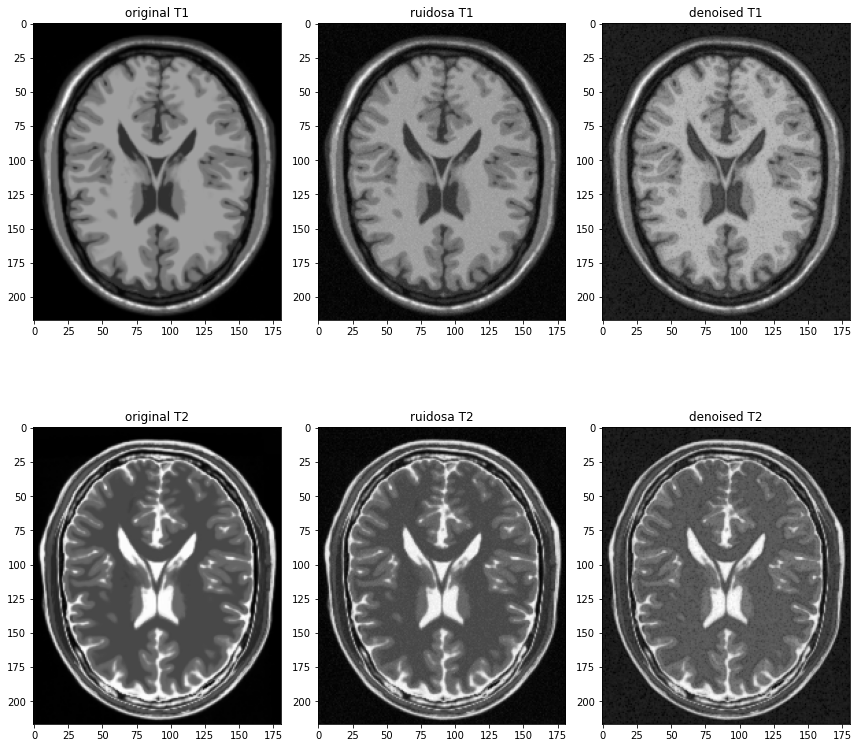

In [9]:
def filter_images(image_file1, image_file2):
    image1 = read_image(image_file1)
    image2 = read_image(image_file2)
    noise_image1 = add_noise(image=image1, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)
    noise_image2 = add_noise(image=image2, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)
    denoised_image1, denoised_image2 = dif_aniso_mc(im1=noise_image1, im2=noise_image2, niter=10, k=8, l=0.25, option=1)

    fig, ax = plt.subplots(2, 3, figsize=(12, 12), tight_layout={
            'rect': [0, 0, 1, 0.98]
        }
    )
    ax[0,0].imshow(image1, cmap='gray')
    ax[0,0].set_title('original T1')
    ax[0,1].imshow(noise_image1, cmap='gray')
    ax[0,1].set_title('ruidosa T1')
    ax[0,2].imshow(denoised_image1, cmap='gray')
    ax[0,2].set_title("denoised T1")

    ax[1,0].imshow(image2, cmap='gray')
    ax[1,0].set_title('original T2')
    ax[1,1].imshow(noise_image2, cmap='gray')
    ax[1,1].set_title('ruidosa T2')
    ax[1,2].imshow(denoised_image2, cmap='gray')
    ax[1,2].set_title("denoised T2")

filter_images("materiales/T1.png", "materiales/T2.png")

# <span style="color:darkcyan">EJERCICIO 2</span>

En este ejercicio se pide implementar el algoritmo Non Local Means para el filtrado de imágenes médicas. Este se encuentra en el fichero NLM_filter.py. 

Para poder aplicar el filtro, primero es necesario poseer una imagen con ruido, por lo que a nuestra imagen original le añadimos este. Se encuentra en el archivo noise.py.

A continuación, se muestran las funciones creadas para este ejercicio.

In [22]:
def filter_NLM(image_file, ws, h, p):
    
    image = cv2.imread(image_file, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float64)
    noise_image = add_noise(image=image, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)
    denoised_image = nlm(noise_image, ws, h, p)     
        
    fig, ax = plt.subplots(1, 3, figsize=(12, 12), tight_layout={
            'rect': [0, 0, 1, 0.98]
        }
    )
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Imagen original')
    ax[1].imshow(noise_image, cmap='gray')
    ax[1].set_title('Imagen ruidosa')
    ax[2].imshow(denoised_image, cmap='gray')
    ax[2].set_title("Imagen filtrada con NLM")
    

In [23]:
def filter_gaussian(image_file, kernel):
    
    image = cv2.imread(image_file, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float64)
    noise_image = add_noise(image=image, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)   
    denoised_image = cv2.GaussianBlur(noise_image, kernel, 0)
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 12), tight_layout={
            'rect': [0, 0, 1, 0.98]
        }
    )
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Imagen original')
    ax[1].imshow(noise_image, cmap='gray')
    ax[1].set_title('Imagen ruidosa')
    ax[2].imshow(denoised_image, cmap='gray')
    ax[2].set_title("Imagen filtrada con filtro gaussiano")

In [24]:
def filter_dif_aniso(image_file):
    image = cv2.imread(image_file, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float64)
    noise_image = add_noise(image=image, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)
    denoised_image = dif_aniso(im=noise_image, niter=10, k=8, l=0.40, option=1)

    fig, ax = plt.subplots(1, 3, figsize=(8.4, 14.4), tight_layout={
            'rect': [0, 0, 1, 0.98]
        }
    )
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Imagen original')
    ax[1].imshow(noise_image, cmap='gray')
    ax[1].set_title('Imagen ruidosa')
    ax[2].imshow(denoised_image, cmap='gray')
    ax[2].set_title("Imagen filtrada con filtro Perona y Malik")

In [39]:
def compare(image_file):
    
    image = cv2.imread(image_file, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float64)
    noise_image = add_noise(image=image, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)
    denoised_NLM = nlm(noise_image, 3, 10, 5)
    denoised_blur = cv2.GaussianBlur(noise_image, (5, 5), 0)
    denoised_dif_aniso = dif_aniso(im=noise_image, niter=10, k=8, l=0.40, option=1)
    
    fig, ax = plt.subplots(2, 3, figsize=(12, 12), tight_layout={
            'rect': [0, 0, 1, 0.98]
        }
    )
    ax[0, 0].imshow(image, cmap='gray')
    ax[0, 0].set_title('Imagen original')
    ax[0, 1].imshow(noise_image, cmap='gray')
    ax[0, 1].set_title('Imagen ruidosa')
    ax[0, 2].axis('off')
    ax[1, 0].imshow(denoised_NLM, cmap='gray')
    ax[1, 0].set_title("Imagen filtrada con NLM")
    ax[1, 1].imshow(denoised_blur, cmap='gray')
    ax[1, 1].set_title('Imagen filtrada con filtro gaussiano')
    ax[1, 2].imshow(denoised_dif_aniso, cmap='gray')
    ax[1, 2].set_title('Imagen filtrada con filtro de Perona y Malik')
    

###  <span style="color:darkcyan"> - 1. Conceptos previos</span>

Como se ha visto, el método Non-Local Means (NLM) consiste en filtrar la imagen por media ponderada de los diferentes píxeles de la imagen en función de su similitud con el píxel original.

Para cumplir con esta parte de la práctica se implementará el algoritmo básico de NLM con parches de tamaño variable alrededor del píxel que se quiere comparar. 

####  Algoritmo Non-Local Means

Este método consiste en calcular el valor de cada píxel mediante el promedio ponderado de todos los píxeles de la imagen en función de la similitud que tengan con respecto el píxel a filtrar. Por lo tanto, en lugar de calcular el promedio de los vecinos dentro de la propia sub-imagen, se busca un parche que sea similar a la sub-imagen  inicial con la que filtrar. 

De forma matemática:

$$
\quad NL[v](i) = \sum_{j∈l} w(i,j)v(j)
$$


- w(i,j) = depende de la similitud entre el píxel a filtrar v(i) y el píxel con el que se está comparando v(j).

El píxel debe ser similar a píxeles similares, no necesariamente a sus vecinos. w(i, j) se calcula de la siguiente forma:

$$
\quad w(i,j) = \frac{1}{Z(i)} \exp ^(\frac{-d(i,j)}{h^2})
$$

- $ h^2 $: parámetro de similitud asociado al grado de filtrado

- d(i,j) = distancia euclídea entre los píxeles de un parche centrado en v(i, j) y los de otro centrado en v(j). 

$$
\quad d(i,j) = || v(N_i) - v(N_j) ||^2 = \sqrt{\sum_{i = 1}^{n} (p_i - q_i)^2}
$$

Para normalizar el valor final utilizamos: 

$$
\quad Z(i) = \sum_{∀j} \exp^(\frac{-d(i,j)}{h^2})
$$

A continuación, se aplica el algoritmo a nuestras imágenes ruidosas. 

###  <span style="color:darkcyan"> - 2. Aplicación de distintos filtros a imágenes médicas ruidosas</span>

Para comparar el filtrado de Non-Local Means, se utilizarán también un filtro gaussiano y el filtro de Perona y Malik. Comenzaremos con el filtro de Non-Local Means. 

#### 2.1. Non-Local Means

Comenzaremos variando el parámetro h.

##### Variación del parámetro h

- h = 0.5

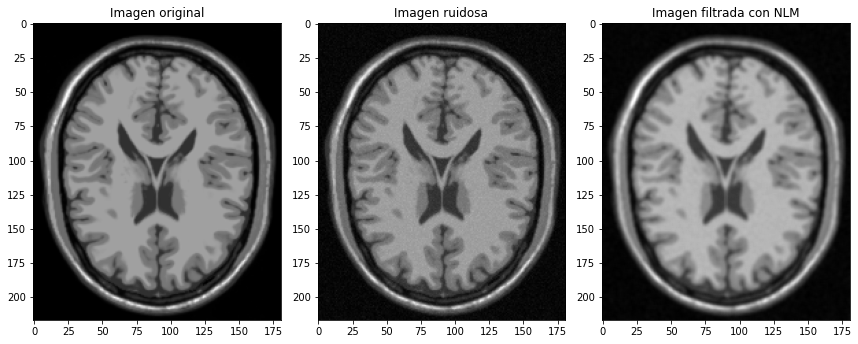

In [40]:
#%matplotlib inline
filter_NLM('materiales/T1.png', 3, 0.5, 5)

- h = 5

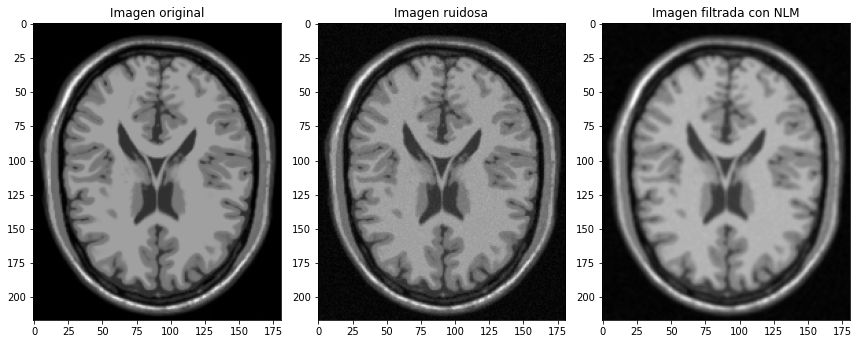

In [41]:
filter_NLM('materiales/T1.png', 3, 5, 5)

- h = 10

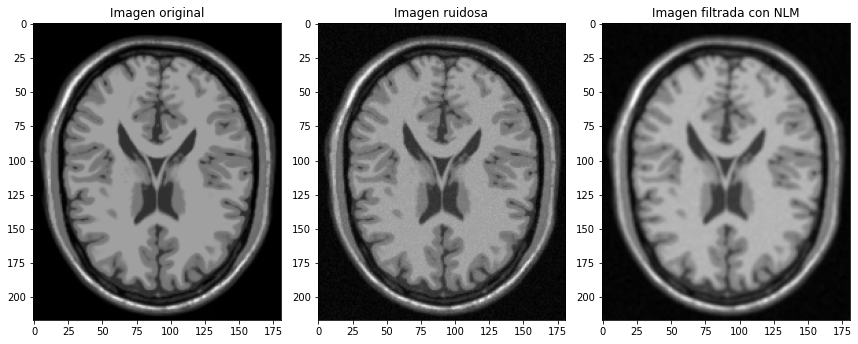

In [42]:
filter_NLM('materiales/T1.png', 3, 10, 5)

- h = 50

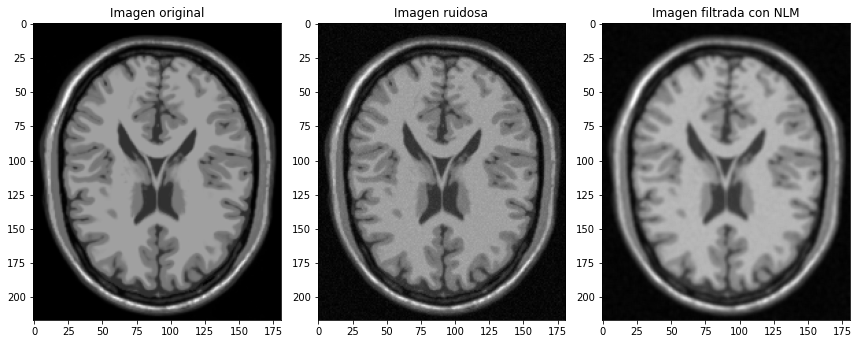

In [43]:
filter_NLM('Materiales/T1.png', 3, 50, 5)

#### Variación del tamaño del parche

- ws = 3

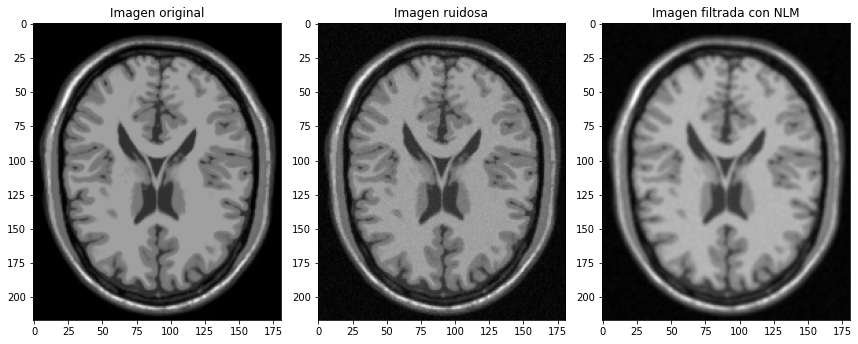

In [44]:
filter_NLM('Materiales/T1.png', 3, 10, 100)

- ws = 7

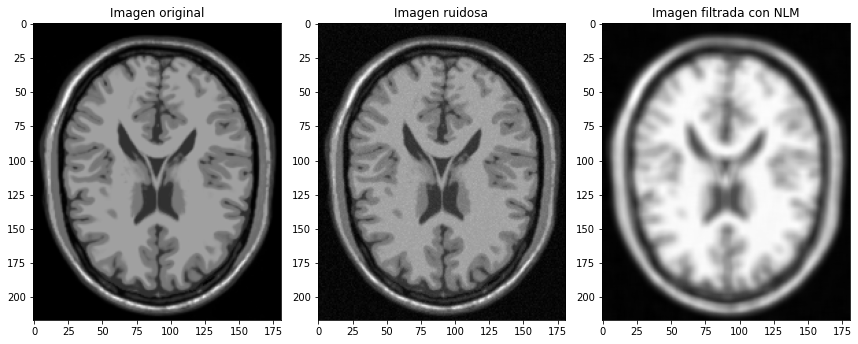

In [45]:
filter_NLM('Materiales/T1.png', 7, 10, 100)

- ws = 15

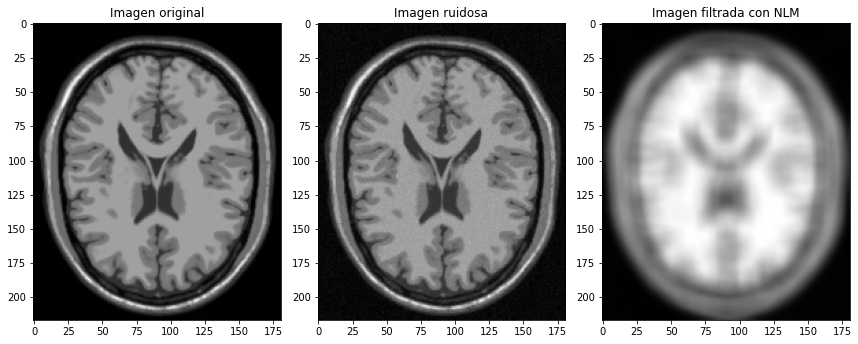

In [46]:
filter_NLM('Materiales/T1.png', 15, 10, 100)

- ws = 31

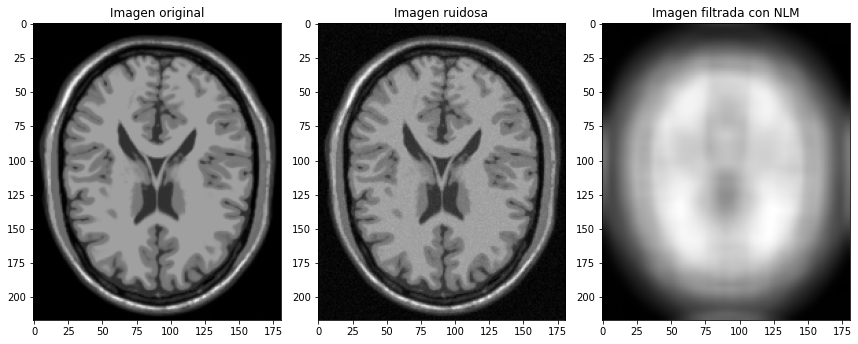

In [47]:
filter_NLM('Materiales/T1.png', 31, 10, 100)

En cuanto al parámetro h, se observa que no se producen cambios significativos en el filtrado de la imagen. Por otra parte, a medida que se aumenta el tamaño de la ventana, la imagen, aunque elimina el ruido que hay en ella, se vuelve demasiado borrosa. Por lo tanto, el mejor valor para esta imagen en concreto, es mejor un tamaño de 3x3. 

#### 2.2. Filtro gaussiano

Para este filtro se comprobarán distintos kernels hasta encontrar el kernel más óptimo para estas imágenes médicas. 

- Kernel: 3x3

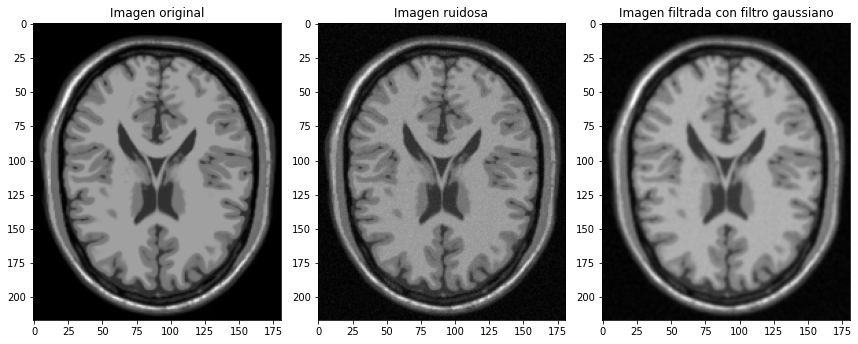

In [48]:
filter_gaussian('Materiales/T1.png', (3, 3))

- Kernel: 5x5

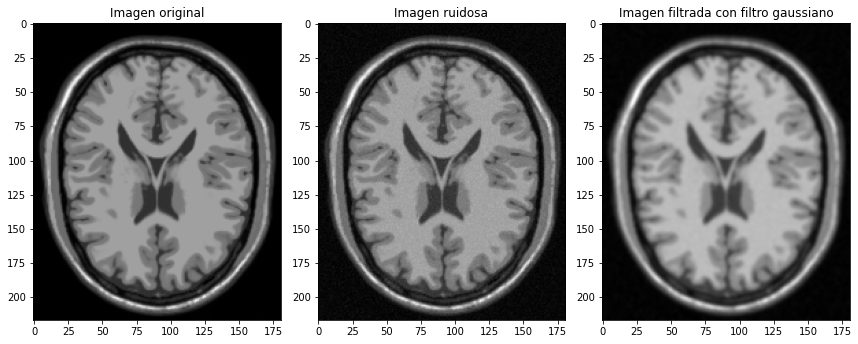

In [49]:
filter_gaussian('Materiales/T1.png', (5, 5))

- Kernel: 7x7

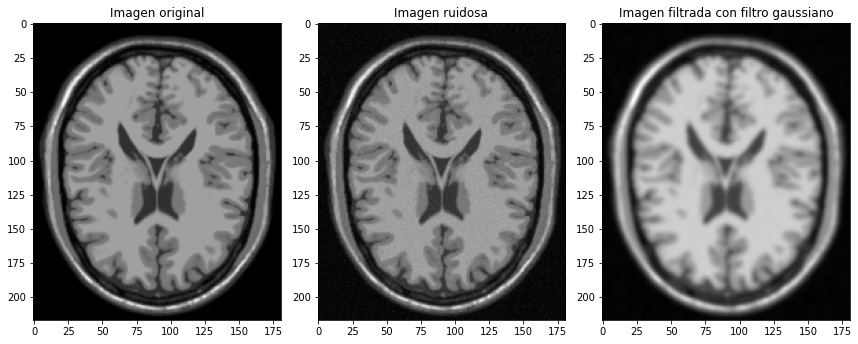

In [50]:
filter_gaussian('Materiales/T1.png', (7, 7))

- Kernel: 11x11

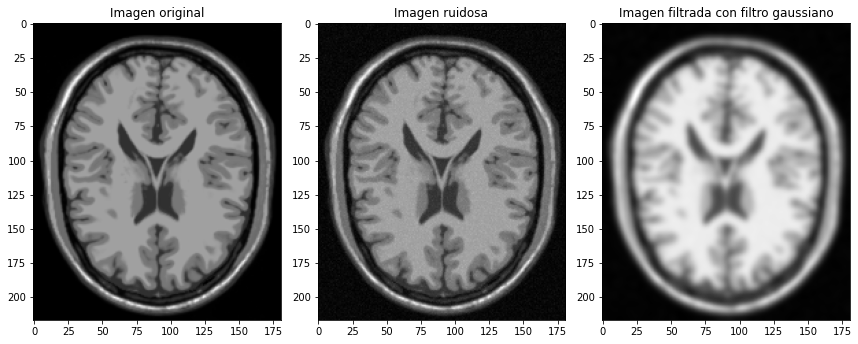

In [51]:
filter_gaussian('Materiales/T1.png', (11, 11))

A medida que aumentamos el kernel, la imagen se vuelve más borrosa, aunque elimine el ruido de la imagen. Para estas imágenes, el kernel más apropiado es 3x3. 

#### 2.3. Filtro de Perona y Malik

Para este algoritmo no será necesario buscar los parámetros más apropiados, ya que esto se ha realizado en el ejercicio anterior. Por lo tanto, se comparará en el próximo apartado los tres filtros creados.

###  <span style="color:darkcyan"> - 3. Comparación entre filtros</span>

A continuación, se compararán las imágenes ruidosas aplicando los tres filtros diseñados.

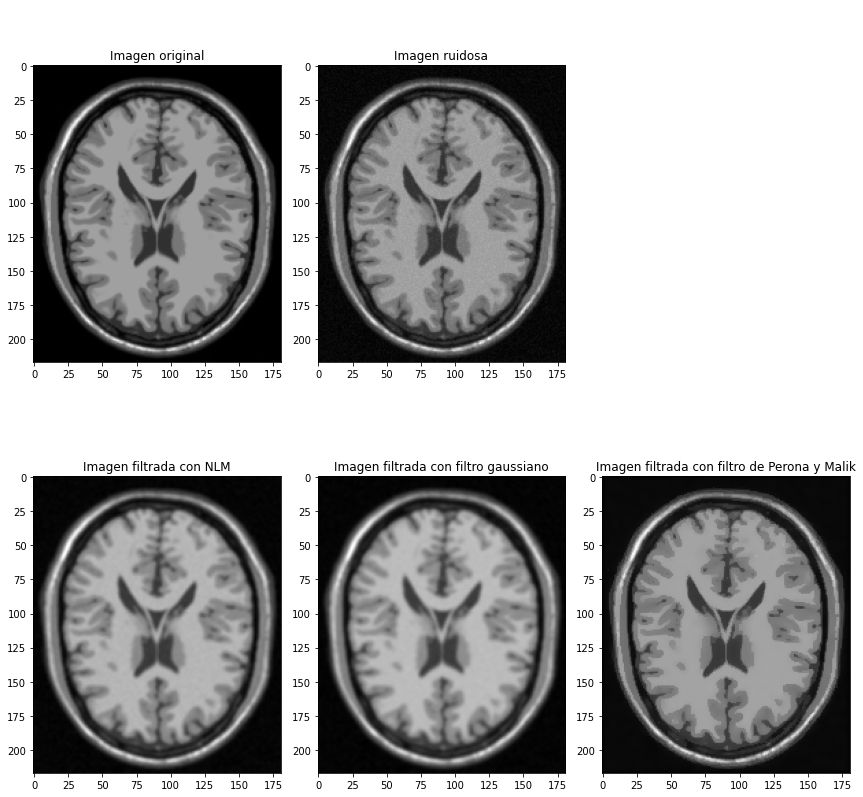

In [52]:
compare('Materiales/T1.png')

Se observa, a grandes rasgos, que entre los filtros de Non Local Means y gaussiano no existe una diferencia significativa cuando tratamos de visualizar la imagen completa. Por otra parte, el filtro de Perona y Malik conserva mejor la imagen y los bordes de esta. Esto es debido a que zonas con gradiente elevado, es decir, bordes, sufren una menor difusión que zonas con un gradiente más bajo. 

Para observar mejor los cambios que se producen con los filtros NLM y gaussiano, escogemos una zona más reducida de la imagen para visualizar con más detalle lo que ocurre en ella. 

Text(0.5, 1.0, 'Imagen recortada')

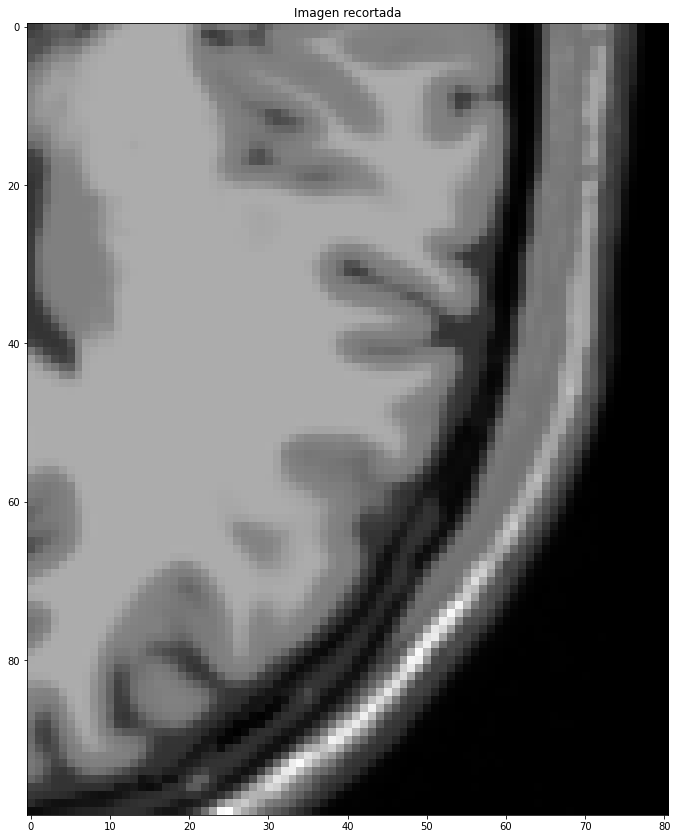

In [57]:
image = cv2.imread('materiales/T1.png', cv2.COLOR_BGR2GRAY)
image = image.astype(np.float64)
image = image[100:200, 100:200]

fig, ax = plt.subplots(1, 1, figsize=(12, 12), tight_layout={
        'rect': [0, 0, 1, 0.98]
    }
)
ax.imshow(image, cmap='gray')
ax.set_title('Imagen recortada')

Se le aplican los mismos pasos que a las imágenes anteriores.

Text(0.5, 1.0, 'Imagen filtrada con filtro gaussiano')

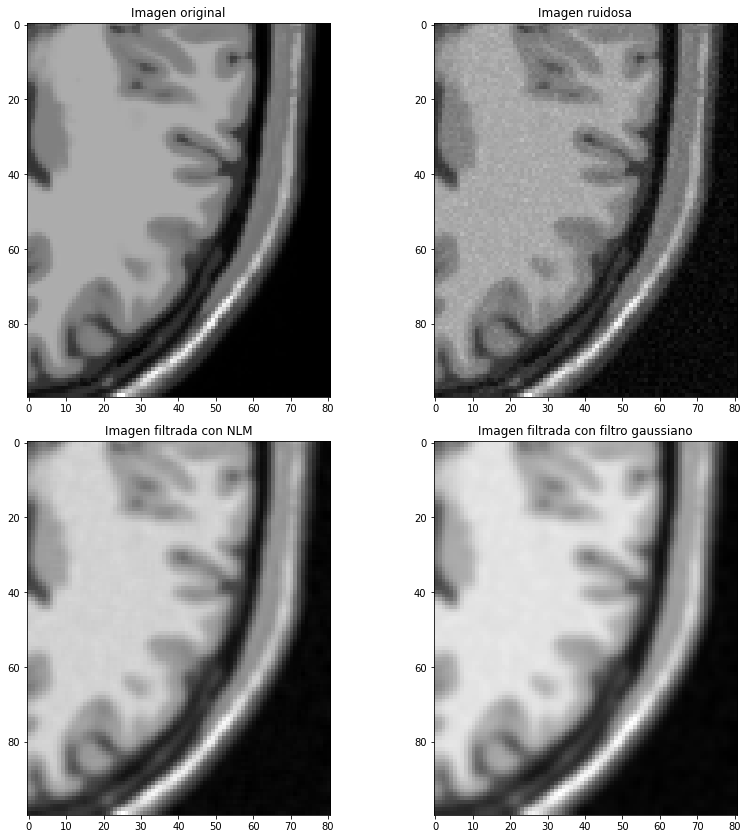

In [55]:
noise_image = add_noise(image=image, noise_type=NoiseTypes.RICIAN_NOISE, intensity=0.1)
denoised_NLM = nlm(noise_image, 3, 10, 5)
denoised_blur = cv2.GaussianBlur(noise_image, (5, 5), 0)

fig, ax = plt.subplots(2, 2, figsize=(12, 12), tight_layout={
        'rect': [0, 0, 1, 0.98]
    }
)
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Imagen original')
ax[0, 1].imshow(noise_image, cmap='gray')
ax[0, 1].set_title('Imagen ruidosa')
ax[1, 0].imshow(denoised_NLM, cmap='gray')
ax[1, 0].set_title("Imagen filtrada con NLM")
ax[1, 1].imshow(denoised_blur, cmap='gray')
ax[1, 1].set_title('Imagen filtrada con filtro gaussiano')

Con la imagen recortada se observan algunas diferencias. La principal diferencia es el emborronamiento de los bordes. El filtro gaussiano provoca un emborronamiento mayor de la imagen, principalmente en los bordes.  

Por su parte, el filtro NLM permite analizar y comparar píxeles por su similitud y no por sus ubicaciones adyacentes, por lo que no se pierde tanta información en los bordes, como sí ocurre con el filtro gaussiano.

# <span style="color:darkcyan">EJERCICIO 3</span>

## <span style="color:darkcyan">EJERCICIO 4</span>

Se ha implementado el script de Python **iron_map.py** para generar los mapas de **R2** y **T2** a partir del conjunto de adquisiciones asociadas a cada paciente, localizadas en el directorio **Hierro**.

A continuación, se procede a detallar las consideraciones tomadas en cuenta para la implementación de citado script. 

###  <span style="color:darkcyan"> - Obtención de imágenes y tiempos de eco asociados</span>

En esta sección se procede a leer las imágenes contenidas en el directorio './Hierro', ordenadas en función de sus tiempos de eco (de menor a mayor).

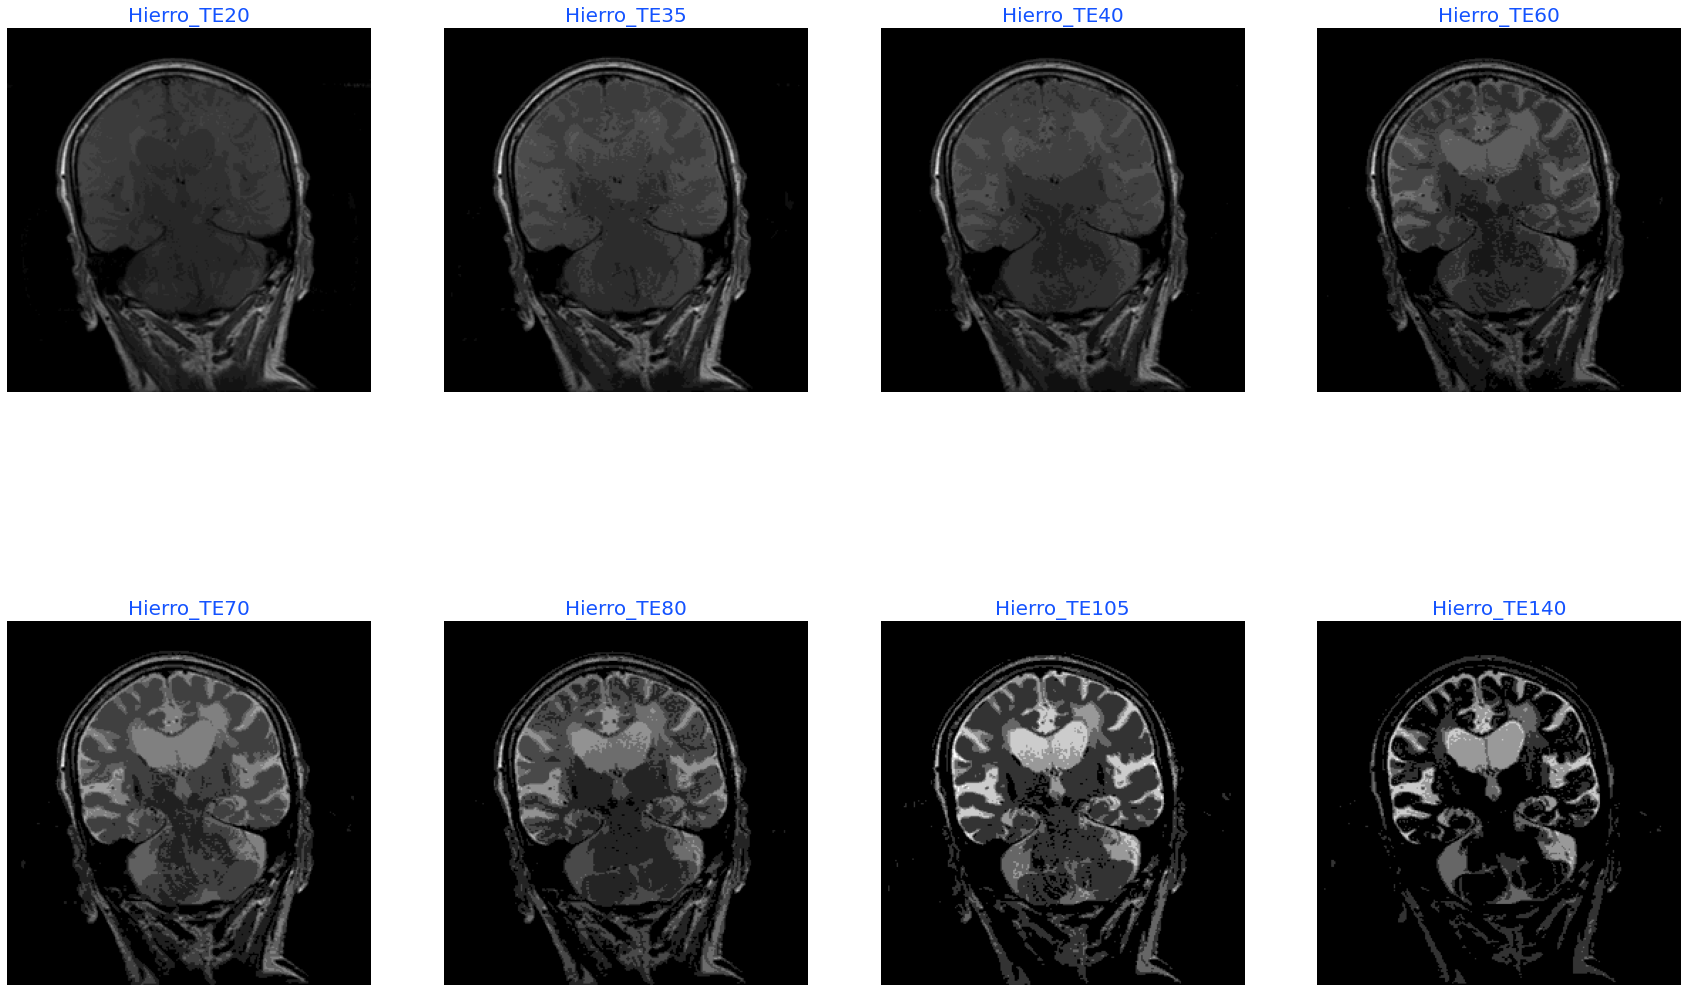

In [58]:
mri_names = [(img_name) for img_name in os.listdir('./materiales/Hierro') if img_name.startswith('Hierro')]
TE = [(int(mri_names[i].split('TE')[1].split('.')[0])) for i in range(len(mri_names))]
names_sorted = [name for _, name in sorted(zip(TE, mri_names))]
TE_sorted = sorted(TE)
mri_imgs = [(cv2.imread('./materiales/Hierro/' + mri, 0)) for mri in names_sorted]

fig = plt.figure(figsize=(30, 20))
for k in range (0,len(mri_imgs)):    
    temp = 241 + k  
    ax = plt.subplot(temp)
    ax.imshow(mri_imgs[k], cmap='gray')
    plt.title(names_sorted[k].split('.')[0], color = '#1453ff', size = 20)
    plt.axis('off')

###  <span style="color:darkcyan"> - Agregar padding a las imágenes para garantizar mismas dimensiones</span>

In [59]:
h, w = mri_imgs[0].shape
mri_imgs = [cv2.copyMakeBorder(mri, h - mri.shape[0], 0, w - mri.shape[1], 0, cv2.BORDER_CONSTANT) for mri in mri_imgs]

###  <span style="color:darkcyan"> - Obtener imágenes parámetricas</span>

En esta sección se obtienen los mapas **R2** y **T2** partiendo de la expresión:

\begin{equation*}
S_i(t) = S_0 \cdot e^{\frac{-TE_i}{T_2}}
\end{equation*}

Donde $S_i$ se asocia a la intensidad de los píxeles de la adquisición y $TE$ representa el tiempo de eco. Para proceder a la obtención de las imágenes paramétricas requeridas, se lleva a cabo una optimización por mínimos cuadrados de la siguiente expresión:

\begin{equation*}
y = A \cdot e^{(B \cdot x)}
\end{equation*}

\begin{equation*}
\ln y = \ln A + B \cdot x
\end{equation*}
    
Donde $A = S_0$, $B = -R2 = -\frac{1}{T_2}$, $x = TE$ e $y = S_i$

Resulta necesario indicar, que para llevar a cabo el proceso de optimización, se consideran todas las imágenes del paciente en cuestión. No obstante, cabe resaltar que con el objetivo de evitar la presencia de indeterminaciones, los valores de intensidad iguales a 0 son descartados.

In [60]:
R2 = np.zeros((h, w))

for i in range(h):
    for j in range(w):
        y = np.array([(mri_imgs[k][i, j]) for k in range(len(mri_imgs))])
        y_refined = np.delete(y, np.where(y == 0))
        x_refined = np.delete(TE_sorted, np.where(y == 0))
        if len(y_refined) >= 2:
            log_y = np.log(y_refined, dtype=np.float64) 
            B, ln_A = np.polyfit(x_refined, log_y, 1, w = np.sqrt(y_refined))
            R2[i, j] = - B

###  <span style="color:darkcyan"> - Normalización de imágenes resultantes y representación de resultados obtenidos</span>

Text(0.5, 1.0, 'T2 (normalizado)')

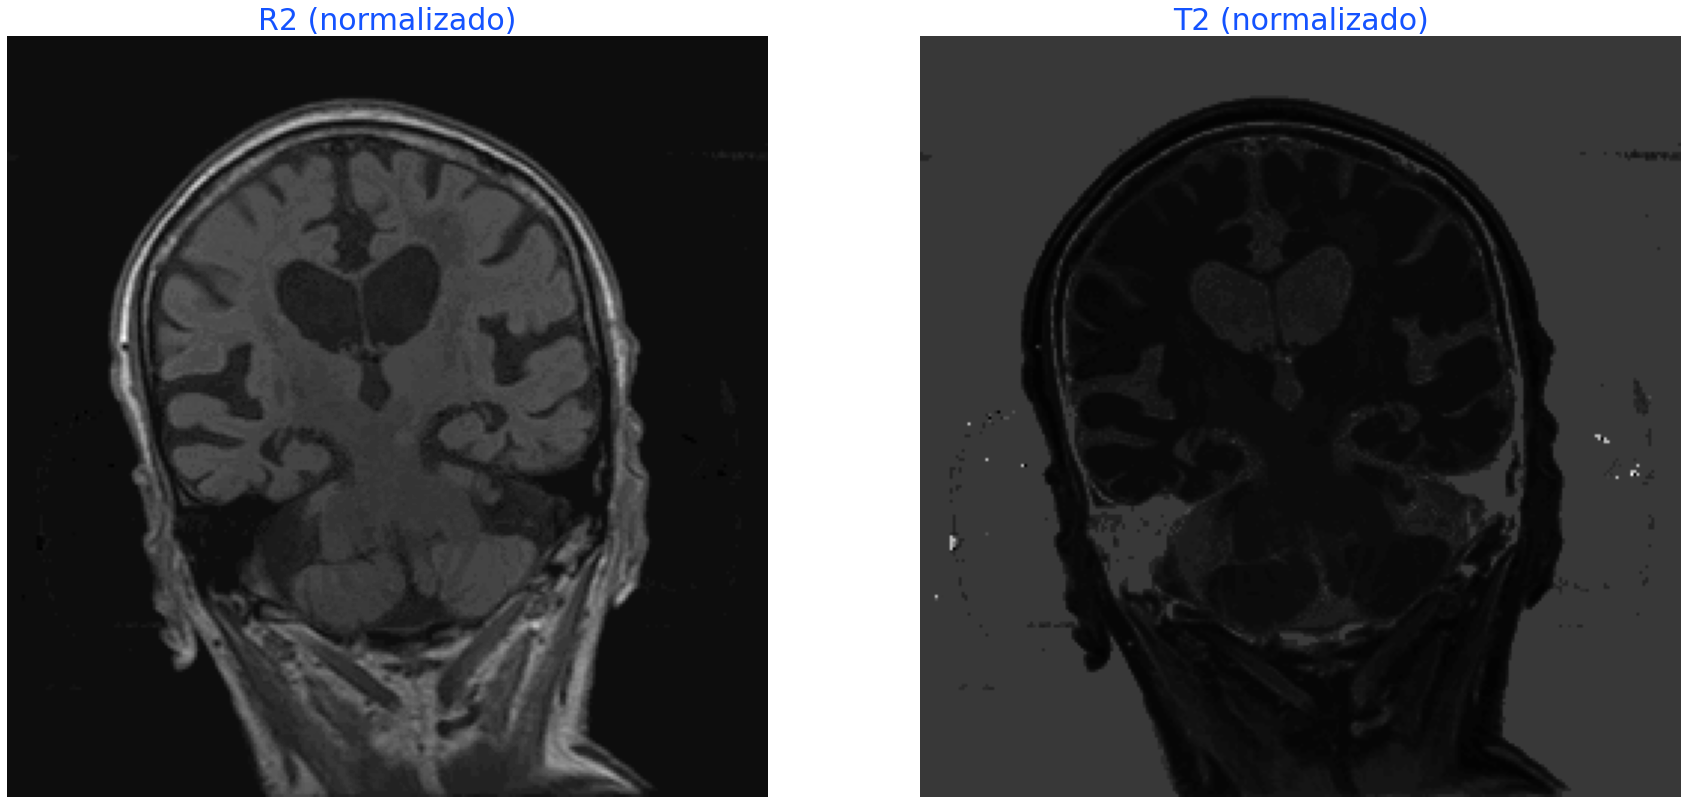

In [61]:
R2_norm = (R2 - np.min(R2)) / (np.max(R2) - np.min(R2)) 
R2_norm = (R2_norm * 255).astype(np.uint8)

T2 = np.zeros((h, w))
T2[R2_norm != 0] =  1 / R2_norm[R2_norm != 0]
T2_norm = (T2 * 255).astype(np.uint8)


plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(R2_norm, cmap='gray')
plt.title('R2 (normalizado)', color='#1453ff', size=30)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(T2_norm, cmap='gray')
plt.title('T2 (normalizado)', color='#1453ff', size=30)



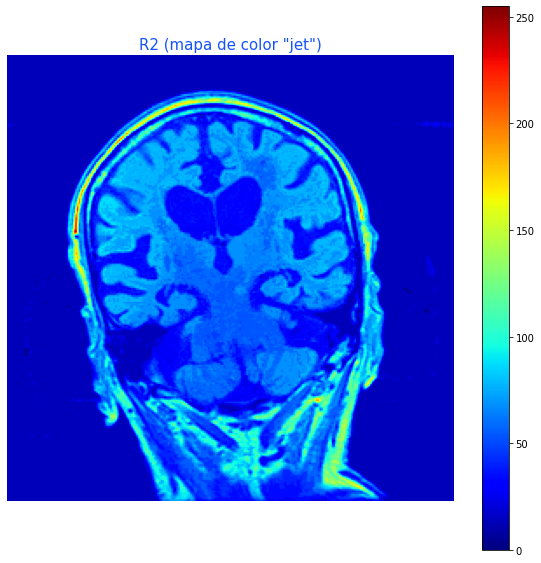

In [62]:
plt.figure(figsize=(10, 10))

plt.imshow(R2_norm, cmap='jet')
plt.axis('off')
plt.title('R2 (mapa de color "jet")', color='#1453ff', size=15)
plt.colorbar()
